In [1]:
import sys
sys.path.append("../")

In [2]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch

from inverse_warp import inverse_warp

In [3]:
def read_img(filepath):
    img = imageio.imread(filepath)
    img = img[:, :, :3]

    img_tensor = np.transpose(img, (2, 0, 1))
    img_tensor = torch.from_numpy(img_tensor.astype(np.float32)).unsqueeze(0)

    return img_tensor

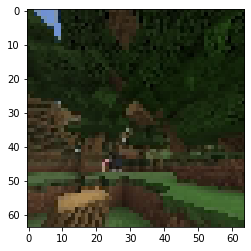

In [4]:
img_orig = imageio.imread("../mc/101.png")
img_orig = img_orig[:, :, :3]

plt.imshow(img_orig)
plt.show()
img = np.transpose(img_orig, (2, 0, 1))
img = torch.from_numpy(img.astype(np.float32)).unsqueeze(0)

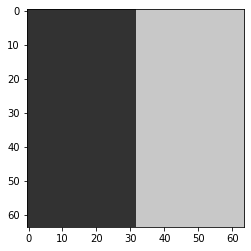

In [5]:
depth_split = np.ones((64, 64, 1), dtype=np.uint8)
depth_split[:, 0:32] = 50
depth_split[:, 32:] = 200

plt.imshow(depth_split, cmap="gray", vmin=0, vmax=255)
plt.show()

depth_split = np.transpose(depth_split, (2, 0, 1))
depth_split = torch.from_numpy(depth_split.astype(np.float32))

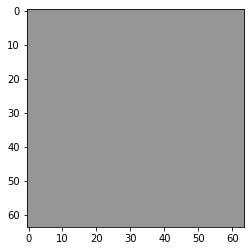

In [6]:
depth_plane = np.full((64, 64, 1), 150, dtype=np.uint8)

plt.imshow(depth_plane, cmap="gray", vmin=0, vmax=255)
plt.show()

depth_plane = np.transpose(depth_plane, (2, 0, 1))
depth_plane = torch.from_numpy(depth_plane.astype(np.float32))

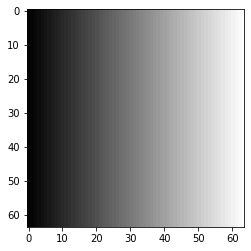

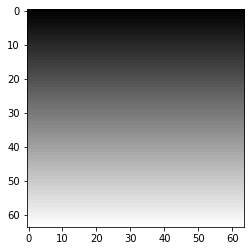

In [7]:
x = np.linspace(0, 255, 64, dtype=np.uint8)
y = np.linspace(0, 255, 64, dtype=np.uint8)
xv, yv = np.meshgrid(x, y)

plt.imshow(xv, cmap="gray", vmin=0, vmax=255)
plt.show()
plt.imshow(yv, cmap="gray", vmin=0, vmax=255)
plt.show()

xv = np.expand_dims(xv, axis=-1)
yv = np.expand_dims(yv, axis=-1)

xv = np.transpose(xv, (2, 0, 1))
depth_grad_horiz = torch.from_numpy(xv.astype(np.float32))
yv = np.transpose(yv, (2, 0, 1))
depth_grad_vert = torch.from_numpy(yv.astype(np.float32))

In [8]:
focal_length = 2

intrinsics = np.array([[focal_length, 0, img.shape[-1]/2],
                       [0, focal_length, img.shape[-1]/2],
                       [0, 0, 1]])
intrinsics = torch.from_numpy(intrinsics.astype(np.float32)).unsqueeze(0)

In [9]:
pose = np.array([0, 0, 0, 0, 0, 0])
pose = torch.from_numpy(pose.astype(np.float32)).unsqueeze(0)

In [10]:
projected_img, valid_points = inverse_warp(img, depth_split, pose, intrinsics)

In [11]:
projected_img = projected_img.squeeze(0)
projected_img = np.transpose(projected_img, (1, 2, 0))

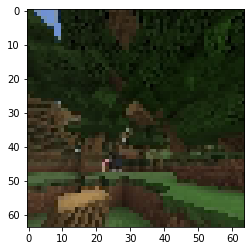

In [12]:
plt.imshow(projected_img.numpy().astype(np.uint8))
plt.show()

6d pose = tx, ty, tz, yaw, pitch, roll

# Photometric loss:

- mean of the absolute difference between original image and warped image
- only valid points from the warped image are used

In [13]:
def photometric_loss(img, depth_img, pose, intrinsics):
    warped_img, valid_points = inverse_warp(img, depth_img, pose, intrinsics)
    
    diff = (img - warped_img) * valid_points.unsqueeze(1).float()
    return diff.abs().mean(), diff, warped_img, valid_points

## Interactive

In [14]:
from ipywidgets import interactive, Output, FloatSlider
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

output = Output()


@output.capture(clear_output=True)
def f(tx, ty, tz, yaw, pitch, roll, depth):
    pose = np.array([tx, ty, tz, yaw, pitch, roll])
    pose = torch.from_numpy(pose.astype(np.float32)).unsqueeze(0)

    if depth == 0:
        depth_img = depth_split
    elif depth == 1:
        depth_img = depth_grad_horiz
    elif depth == 2:
        depth_img = depth_grad_vert
    elif depth == 3:
        depth_img = depth_plane
        
    reconstruction_loss, _, warped_img, valid_points = photometric_loss(img, depth_img, pose, intrinsics)
    
    print("reconstruction loss: {:.8f}".format(float(reconstruction_loss)))
    
    warped_img = warped_img.squeeze(0)
    warped_img = np.transpose(warped_img, (1, 2, 0))

    plt.figure(figsize=(15, 15), dpi=80)

    plt.subplot(1, 3, 1)
    plt.imshow(img_orig)

    plt.subplot(1, 3, 2)
    plt.imshow(np.transpose(depth_img, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)

    plt.subplot(1, 3, 3)

    plt.imshow(warped_img.numpy().astype(np.uint8))
    plt.show()

    
interactive_plot = interactive(f,
                               tx=(-1000, 1000, 10),
                               ty=(-1000, 1000, 10),
                               tz=(-1000, 1000, 10),
                               yaw=FloatSlider(min=-0.1, max=0.1, step=0.001, readout_format=".8"),
                               pitch=FloatSlider(min=-0.1, max=0.1, step=0.001, readout_format=".4"),
                               roll=FloatSlider(min=-3.5, max=3.5, step=0.01, readout_format=".4"),
                               depth=[("split", 0),
                                      ("grad horizontal", 1),
                                      ("grad vertical", 2),
                                      ("plane", 3)])

display(interactive_plot)
display(output)

interactive(children=(IntSlider(value=0, description='tx', max=1000, min=-1000, step=10), IntSlider(value=0, d…

Output()

## Limit visualisation

In [15]:
def generate_poses(tx=(-500,500,50), ty=(-500,500,50), tz=(-500,500,50), yaw=(-1,1,0.1), pitch=(-1,1,0.1), roll=(-1,1,0.1)):
    tx = np.linspace(tx[0], tx[1], int((tx[1] - tx[0]) / tx[2] + 1))
    ty = np.linspace(ty[0], ty[1], int((ty[1] - ty[0]) / ty[2] + 1))
    tz = np.linspace(tz[0], tz[1], int((tz[1] - tz[0]) / tz[2] + 1))
    yaw = np.linspace(yaw[0], yaw[1], int((yaw[1] - yaw[0]) / yaw[2] + 1))
    pitch = np.linspace(pitch[0], pitch[1], int((pitch[1] - pitch[0]) / pitch[2] + 1))
    roll = np.linspace(roll[0], roll[1], int((roll[1] - roll[0]) / roll[2] + 1))
    
    return np.array(np.meshgrid(tx, ty, tz, yaw, pitch, roll)).T.reshape(-1,6)


def generate_rotations(yaw=(-1,1,0.1), pitch=(-1,1,0.1), roll=(-1,1,0.1)):
    yaw = np.linspace(yaw[0], yaw[1], int((yaw[1] - yaw[0]) / yaw[2] + 1))
    pitch = np.linspace(pitch[0], pitch[1], int((pitch[1] - pitch[0]) / pitch[2] + 1))
    roll = np.linspace(roll[0], roll[1], int((roll[1] - roll[0]) / roll[2] + 1))
    
    return np.array(np.meshgrid(yaw, pitch, roll)).T.reshape(-1,3)


def generate_translations(tx=(-500,500,10), ty=(-500,500,10), tz=(-500,500,10)):
    tx = np.linspace(tx[0], tx[1], int((tx[1] - tx[0]) / tx[2] + 1))
    ty = np.linspace(ty[0], ty[1], int((ty[1] - ty[0]) / ty[2] + 1))
    tz = np.linspace(tz[0], tz[1], int((tz[1] - tz[0]) / tz[2] + 1))
    
    return np.array(np.meshgrid(tx, ty, tz)).T.reshape(-1,3)

In [16]:
def plot_one_dim_pos(dim, start, stop, step, img, depth_img, intrinsics):
    p = np.linspace(start, stop, int((stop - start) / step + 1))

    photometric_losses = [float(photometric_loss(img, depth_img, torch.from_numpy(np.insert(np.array([0, 0, 0, 0, 0], dtype=np.float32), dim, p).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for p in p]
    
    if dim == 0:
        dimension_label = "x translation"
    elif dim == 1:
        dimension_label = "y translation"
    elif dim == 2:
        dimension_label = "z translation"
    elif dim == 3:
        dimension_label = "yaw"
    elif dim == 4:
        dimension_label = "pitch"
    elif dim == 5:
        dimension_label = "roll"
    
    plt.title(f"{dimension_label} value - photometric loss") 
    plt.xlabel(f"{dimension_label} value") 
    plt.ylabel("photometric loss") 
    plt.plot(p, photometric_losses) 
    plt.show()

    
import plotly.graph_objects as go

def plotly_one_dim_pos(dim, start, stop, step, img, depth_img, intrinsics):
    p = np.linspace(start, stop, int((stop - start) / step + 1))

    photometric_losses = [float(photometric_loss(img, depth_img, torch.from_numpy(np.insert(np.array([0, 0, 0, 0, 0], dtype=np.float32), dim, p).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for p in p]

    if dim == 0:
        dimension_label = "x translation"
    elif dim == 1:
        dimension_label = "y translation"
    elif dim == 2:
        dimension_label = "z translation"
    elif dim == 3:
        dimension_label = "yaw"
    elif dim == 4:
        dimension_label = "pitch"
    elif dim == 5:
        dimension_label = "roll"
        
    fig = go.Figure(data=go.Scatter(x=p, y=photometric_losses))
    fig.show()

### Split depth

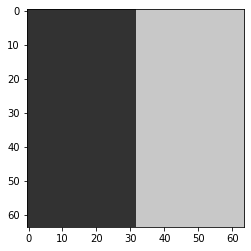

In [17]:
plt.imshow(np.transpose(depth_split, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

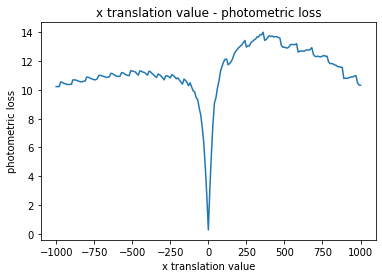

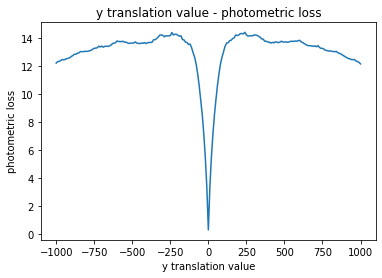

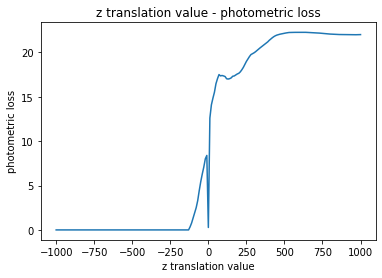

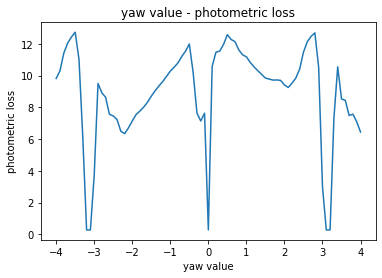

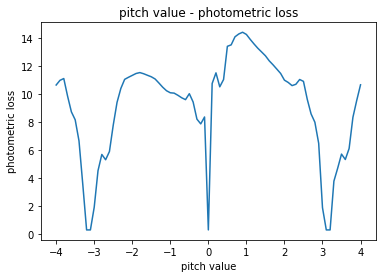

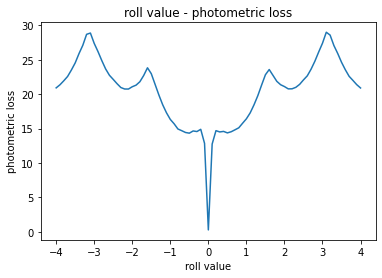

In [18]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)

#### multidimensional

In [19]:
import plotly.graph_objects as go
import numpy as np

translations = generate_translations(tx=(-1000,1000,100), ty=(-1000,1000,100), tz=(-1000,1000,100))

photometric_losses = [float(photometric_loss(img, depth_split, torch.from_numpy(np.concatenate((trans, [0, 0, 0]), axis=0).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for trans in translations]

In [ ]:
data = [go.Scatter3d(x=translations[:,0],
                     y=translations[:,1],
                     z=translations[:,2],
                     mode="markers",
                     marker=dict(
                         size=1,
                         color=photometric_losses,
                         colorscale="Viridis",
                         opacity=0.8
                     ))]

fig = go.Figure(data=data)
fig.show()

In [21]:
import plotly.graph_objects as go
import numpy as np

rotations = generate_rotations(yaw=(-3.6,3.6,0.2), pitch=(-3.6,3.6,0.2), roll=(-3.6,3.6,0.2))

photometric_losses = [float(photometric_loss(img, depth_split, torch.from_numpy(np.concatenate(([0, 0, 0], rot), axis=0).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for rot in rotations]

In [ ]:
data = [go.Scatter3d(x=rotations[:,0],
                     y=rotations[:,1],
                     z=rotations[:,2],
                     mode="markers",
                     marker=dict(
                         size=1,
                         color=photometric_losses,
                         colorscale="Viridis",
                         opacity=0.8
                     ))]

fig = go.Figure(data=data)
fig.show()

In [23]:
import plotly.graph_objects as go
import numpy as np

rotations = generate_rotations(yaw=(-0.1,0.1,0.01), pitch=(-0.1,0.1,0.01), roll=(-0.1,0.1,0.01))

photometric_losses = [float(photometric_loss(img, depth_split, torch.from_numpy(np.concatenate(([0, 0, 0], rot), axis=0).astype(np.float32)).unsqueeze(0), intrinsics)[0]) for rot in rotations]

In [ ]:
data = [go.Scatter3d(x=rotations[:,0],
                     y=rotations[:,1],
                     z=rotations[:,2],
                     mode="markers",
                     marker=dict(
                         size=2,
                         color=photometric_losses,
                         colorscale="Viridis",
                         opacity=0.8
                     ))]

fig = go.Figure(data=data)
fig.show()

### Horizontal gradiend depth

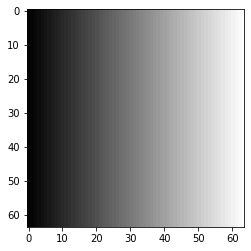

In [25]:
plt.imshow(np.transpose(depth_grad_horiz, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

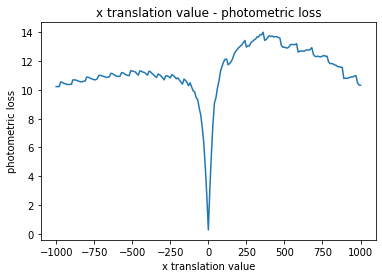

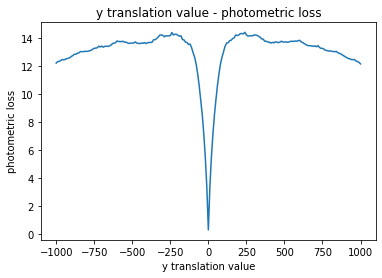

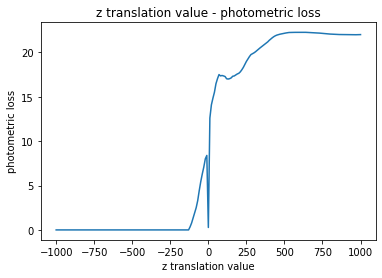

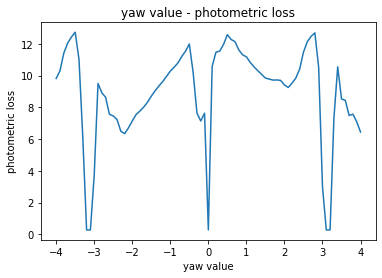

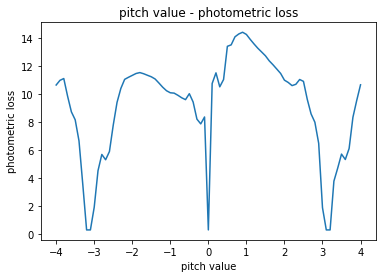

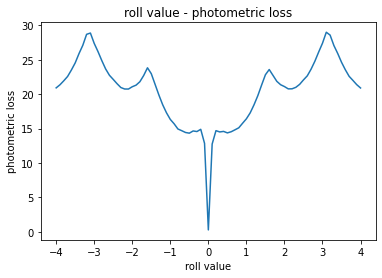

In [26]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_horiz, intrinsics=intrinsics)

### Vertical gradiend depth

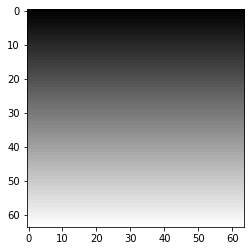

In [27]:
plt.imshow(np.transpose(depth_grad_vert, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

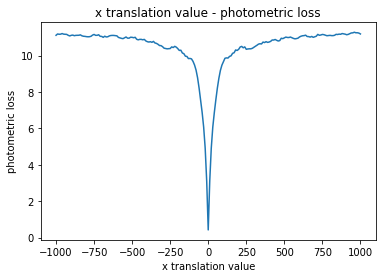

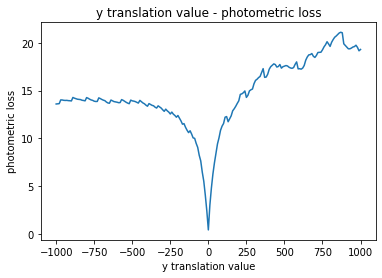

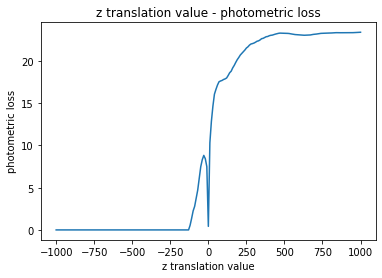

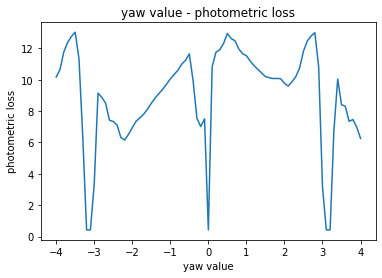

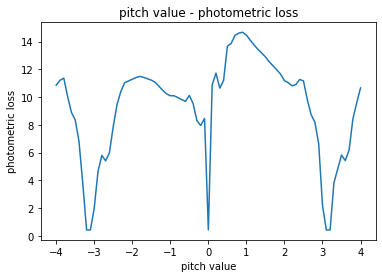

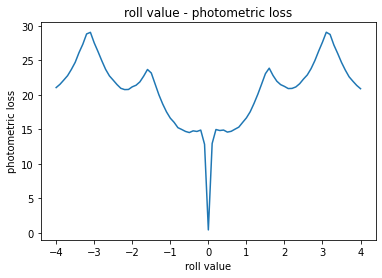

In [28]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.1, img=img, depth_img=depth_grad_vert, intrinsics=intrinsics)

### Plane depth

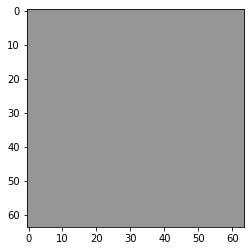

In [29]:
plt.imshow(np.transpose(depth_plane, (1, 2, 0)), cmap="gray", vmin=0, vmax=255)
plt.show()

#### 1D in pose

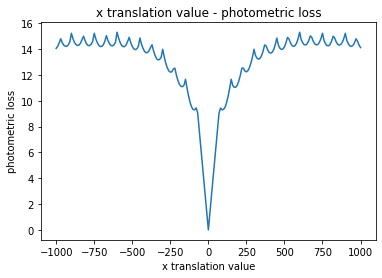

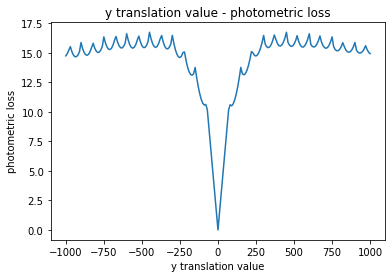

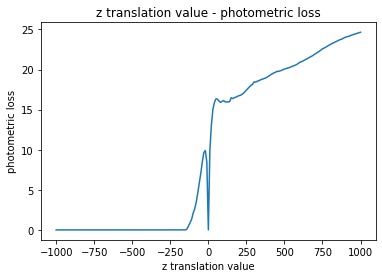

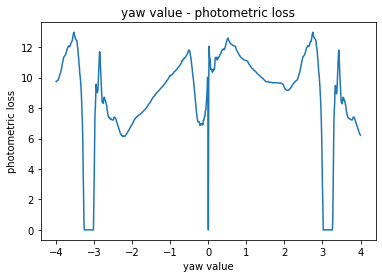

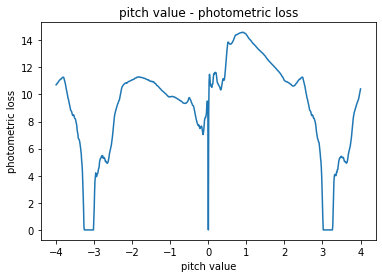

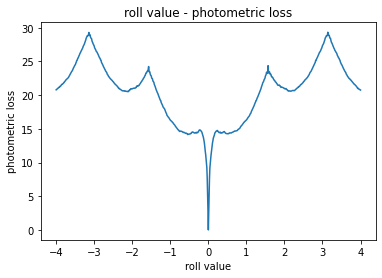

In [30]:
plot_one_dim_pos(dim=0, start=-1000, stop=1000, step=10, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=1, start=-1000, stop=1000, step=10, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=2, start=-1000, stop=1000, step=10, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=3, start=-4, stop=4, step=0.01, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=4, start=-4, stop=4, step=0.01, img=img, depth_img=depth_plane, intrinsics=intrinsics)
plot_one_dim_pos(dim=5, start=-4, stop=4, step=0.01, img=img, depth_img=depth_plane, intrinsics=intrinsics)

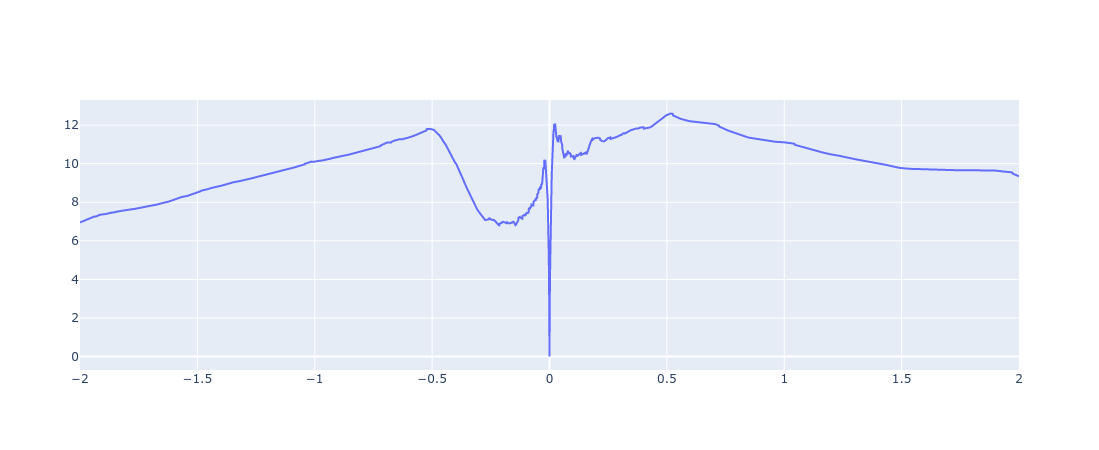

In [31]:
plotly_one_dim_pos(dim=3, start=-2, stop=2, step=0.001, img=img, depth_img=depth_plane, intrinsics=intrinsics)